In [89]:
from astropy.table import join
from astropy.table import Table

from CRTS_paper_modules import update_progress
import CRTS_paper_modules as mod
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir
import pandas as pd 
import imp
imp.reload(mod)


<module 'CRTS_paper_modules' from '/Users/chris/GradResearch/CRTS_PROJECT/code/CRTS_paper_modules.py'>

# CRTS stars 

Aim : want to figure out WHY  all SDSS and CRTS stars can be matched to matching radius of 0.0 ! How is this possible? Are CRTS RA even different ? 
    

In [23]:
# CRTS stars radec

address = '../raw_LC_CRTS/stars/radec.00'
crts_stars_radec = Table.read(address, format='ascii', names=['CRTS_name','ra','dec'])


In [25]:
len(crts_stars_radec)


100000

In [11]:
# SDSS stars

address = '../catalogs_SDSS/stripe82calibStars_v2.6.dat' 
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']
    
sdss_stars = Table.read(address, format='ascii', names = colnames)
    

In [17]:
np.in1d(crts_stars_radec['ra'],sdss_stars['ra'])

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [15]:
len(crts_stars_radec)

100000

 We combine aggregate info of raw LC and proc LC together with SDSS info, using the ra, dec which are for SDSS

In [18]:
# CRTS aggregate info  for stars 
address = '../data_products/CRTS_stars_raw_and_proc_combined_agg.dat'
crts_stars = Table.read(address, format='ascii')

In [26]:
# Add the SDSS ra, dec information.... 
crts_table = join(left=crts_stars, right = crts_stars_radec, keys='CRTS_name')

# It's length is the same as the crts_stars :  48250 / 100000  stars, that fulfill the criteria 
# of being longer than 10 day-averaged epochs 

In [33]:
# Check that indeed all ra are in the SDSS (because they are the same )

np.sum(np.in1d(crts_table['ra'], sdss_stars['ra']))

# Indeed they are! 

48250

In [52]:
len(np.unique(crts_table['dec']))

47748

In [ ]:
# Just join the SDSS info to CRTS table 
#crts_sdss_table = join(left=crts_table, right=sdss_stars )

# Interestingly , for 48250 stars, there are only 47137 unique ra, and 47748 unique dec, i.e. some stars have either 
# the same ra, or the same dec. 

# So it seems that there are 820150 unique dec  , and 656841  unique ra  in sdss_stars.
# even if we join on both 'ra' and 'dec', it seems that still we are getting more than one match from SDSS for
# few stars . Just try using astropy catalog match, and see if it works perhaps better.... 

In [53]:
# Astropy  SkyCoord.match_to_catalog_sky 

cat1_ra  = crts_table['ra']
cat1_dec = crts_table['dec']
cat2_ra  = sdss_stars['ra']
cat2_dec = sdss_stars['dec']

from astropy import units as u
from astropy.coordinates import SkyCoord
cat1 = SkyCoord(ra=cat1_ra*u.degree, dec=cat1_dec*u.degree)
cat2 = SkyCoord(ra=cat2_ra*u.degree, dec=cat2_dec*u.degree)
idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
#idx : indices that match catalog2  to catalog1 : 
#        catalog1[ra]  - catalog2[ra][idx] ~= 0 
# eg. crts_table['dec'] - sdss_stars[idx]['dec'] 

SyntaxError: 'return' outside function (<ipython-input-53-436616adb299>, line 13)

In [60]:
match_angle_deg = sep2d.value
match_angle_arcsec = match_angle_deg * 3600

# take only those rows that are a perfect positional match to our catalog ... 
# even though we didn't have to do this, the fact that some stars share ra or dec made it hard 
# to use join() 
sdss_table = sdss_stars[idx]

In [69]:
from astropy.table import  hstack

sdss_crts_table = hstack([crts_table, sdss_table])

In [70]:
len(sdss_crts_table)

48250

In [75]:
# here ra_1, dec_1  are sdss ra,dec from  radec.00  file in the CRTS raw lightcurves directory ; 
# the ra_2, dec_2  are the sdss  ra,dec  from the stripe82calibStars_v2.6.dat
sdss_crts_table[:5]

raw_mjd_span,raw_mean_mag,raw_mean_err,CRTS_name,raw_lc_length,proc_mean_N_day,proc_mean_err,proc_lc_length,proc_mean_mag,proc_mjd_span,ra_1,dec_1,calib_fla,ra_2,dec_2,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2
float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
3020.85593,17.8823529412,0.0705147058824,251,136.0,3.4,0.0399875,40.0,17.8839675,3020.8452,0.040063,0.55537,CALIBSTARS,0.040063,0.55537,0.038,0.031,9,0.068,9,19.069,19.062,0.009,0.047,2.0,9,18.253,18.251,0.007,0.016,0.6,9,17.919,17.919,0.006,0.014,0.6,9,17.788,17.79,0.006,0.01,0.2,9,17.731,17.734,0.008,0.02,0.7
2892.13763,15.2544047619,0.05,340,84.0,4.0,0.025,21.0,15.2544047619,2892.1202,0.054511,-1.1499029,CALIBSTARS,0.054511,-1.1499029,0.049,0.067,9,0.097,9,17.772,17.77,0.007,0.018,0.7,9,16.012,16.01,0.006,0.014,0.5,9,15.319,15.318,0.006,0.01,0.3,9,15.056,15.057,0.005,0.013,0.5,9,14.938,14.942,0.006,0.016,0.9
3020.85593,17.8416666667,0.0703623188406,425,138.0,3.45,0.039565,40.0,17.84158,3020.8438,0.073721,0.404988,CALIBSTARS,0.073721,0.404988,0.058,0.057,14,0.071,2,22.361,22.358,0.181,0.127,0.2,13,19.855,19.857,0.007,0.033,1.6,13,18.325,18.322,0.005,0.024,1.0,13,17.166,17.171,0.004,0.016,1.1,13,16.54,16.543,0.005,0.024,1.2
3020.85593,19.4547826087,0.113115942029,455,138.0,3.45,0.0637025,40.0,19.4524925,3020.8438,0.078358,0.235094,CALIBSTARS,0.078358,0.235094,0.032,0.036,13,0.085,0,-0.33,-0.33,0.0,0.0,0.0,12,20.936,20.937,0.011,0.03,0.5,12,19.601,19.602,0.007,0.033,1.8,12,18.961,18.971,0.006,0.023,1.6,12,18.615,18.601,0.013,0.066,2.1
3020.85593,14.7506521739,0.05,522,138.0,3.45,0.028005,40.0,14.75144,3020.8438,0.093134,0.751608,CALIBSTARS,0.093134,0.751608,0.032,0.021,5,0.077,5,16.393,16.385,0.007,0.028,1.8,5,15.192,15.192,0.006,0.005,0.1,5,14.798,14.808,0.008,0.03,2.8,5,14.667,14.666,0.008,0.023,0.9,5,14.647,14.645,0.009,0.006,0.1


In [76]:
# Save the combined CRTS - SDSS table for stars... 

address = '../data_products/CRTS_SDSS_combined_stars_catalog.dat'
sdss_crts_table.write(address, format='ascii', overwrite='True')

# CRTS quasars 

Here I use CRTS aggregates on raw and processed lightcurves, and obtain ra,dec information from the filename.  I convert the hms to deg in two  ways:  using a handwritten routine, and using AstroPy SkyCoord.  Both yield exactly the same results : 15 QSO without a counterpart within 50 arcsec... 

In [77]:
# Use the aggregate info on raw and proc CRTS lightcurves, obtain the CRTS ra, dec from filename,


In [79]:
address = '../data_products/CRTS_qso_raw_and_proc_combined_agg.dat'
crts_qso = Table.read(address, format='ascii')



In [107]:
crts_qso['CRTS_name'][0][9:]



'+000225.3'

In [110]:
# extract ra, dec from  CRTS_name   : 

ra_string = [name[:-9] for name in  crts_qso['CRTS_name']]
dec_string  = [name[9:] for name in crts_qso['CRTS_name']]


# Split CRTS  ra, dec from hms to h m s 
ra_hms_split, dec_hms_split = mod.get_ra_dec_CRTS(ra_string, dec_string)

# Convert CRTS  ra, dec from hms to deg  
ra_deg_CRTS, dec_deg_CRTS = mod.convert_to_deg(ra_hms_split, dec_hms_split)



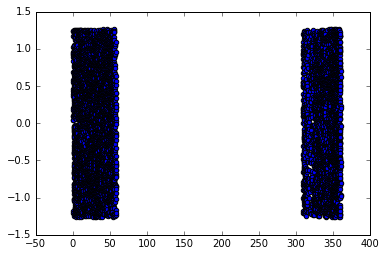

In [154]:
%matplotlib inline
plt.scatter(ra_deg_CRTS, dec_deg_CRTS)



In [200]:
SkyCoord?


In [155]:
from astropy import units as u
from astropy.coordinates import SkyCoord

c = SkyCoord('00 42 30 +41 12 00', unit=(u.hourangle, u.deg))


In [165]:
comb = np.zeros_like(ra_hms_split, dtype='<U31')

for  i in range(len(comb)):
    
    comb[i] = ra_hms_split[i]+' '+dec_hms_split[i]
    
    

In [167]:
comb_c = SkyCoord(comb, unit=(u.hourangle, u.deg))


In [170]:
cat1 = comb_c
cat2_ra  = sdss_qso['ra']
cat2_dec = sdss_qso['dec']
cat2 = SkyCoord(ra=cat2_ra*u.degree, dec=cat2_dec*u.degree)
idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 


In [ ]:
cat1 = SkyCoord(ra=cat1_ra*u.degree, dec=cat1_dec*u.degree)
cat2 = SkyCoord(ra=cat2_ra*u.degree, dec=cat2_dec*u.degree)
idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 



In [171]:
match_angle_deg = sep2d.value
match_angle_arcsec = match_angle_deg * 3600



In [176]:
np.sum(match_angle_arcsec > 1)


15

In [177]:
sdss_qso_table1 = sdss_qso[idx]


In [178]:
match_angle = Column(name='match_angle_arcsec',data= match_angle_arcsec)
sdss_qso_table1.add_column(match_angle)

# add the sdss info to the crts info : stack two tables horizontally 
sdss_crts_table1 = hstack([crts_qso, sdss_qso_table1])


In [181]:
mismatch1 = sdss_crts_table1[sdss_crts_table1['match_angle_arcsec']>2]['CRTS_name']
mismatch = sdss_crts_table[sdss_crts_table['match_angle_arcsec']>2]['CRTS_name']



In [183]:

np.in1d(mismatch, mismatch1)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True], dtype=bool)

In [185]:
# Ok, so these are exactly the same quasars, that are mismatched - there is nothing wrong with my algorithm...

# Check them out ! 

# Make an ascii file with list of ra, dec in degrees, separated by white space, commas (,), or pipes (|). 
# RA and Dec must be in units decimal degrees.



In [198]:
# first, feed the SDSS DR12 with the SDSS coords of mismatched QSO : 
radec_SDSS_mismatch = sdss_crts_table1[sdss_crts_table1['match_angle_arcsec']>2][['ra','dec']]
address = '../data_products/CRTS_SDSS_mismatch_QSO_SDSS_radec.dat'
radec_SDSS_mismatch.write(address, format='ascii', overwrite='True')

# Feed the SDSS with the CRTS coords of mismatched objects .... 

radec_CRTS_mismatch = sdss_crts_table1[sdss_crts_table1['match_angle_arcsec']>2][['ra_CRTS','dec_CRTS']]
address = '../data_products/CRTS_SDSS_mismatch_QSO_CRTS_radec.dat'
radec_CRTS_mismatch.write(address, format='ascii', overwrite='True')

In [ ]:
# Could do https://dr12.sdss.org/bulkFields/raDecs ,but it does not give much useful info...

# Instead, by hand try http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp

# NOTES on individual objects : 

# First, I use  SDSS coords from DB9  to query by hand these 15 objects...

1) SDSS STAR ra=14.16039248, dec=0.61147335,   ObjId = 588015509812412634 : 
    
2) SDSS GALAXY ra=16.57797276, dec=-0.36779433,   ObjId = 588015508739719362

3) SDSS STAR    ra=21.79044991, dec=-0.82312779,   ObjId = 588015508205142178

4) SDSS STAR    ra=23.57580185, dec=0.26019066,   ObjId = 587731513144770582

5) SDSS STAR    ra=30.27577764, dec=-0.9485065,   ObjId = 587731511537041576

6) SDSS STAR    ra=43.79397299, dec=-0.12030369,   ObjId = 587731512616747105

7) SDSS STAR    ra=44.02973877, dec=1.07722393,   ObjId = 587731514227425430

8) SDSS STAR    ra=51.85132224, dec=-0.85782689,   ObjId = 587731511546478754

9) SDSS STAR    ra=55.73044693, dec=0.8231733,   ObjId = 587731513695666438

10) SDSS STAR    ra=311.17075564, dec=0.94198223,   ObjId = 587730848497206143
--> crowded field 

11) SDSS STAR    ra=335.40398149, dec=0.19558045,   ObjId = 587734304878690655

12) SDSS STAR    ra=343.92565411, dec=-1.12342469,   ObjId = 587734303271813146

13) SDSS STAR    ra=348.04136769, dec=-0.94963622,   ObjId = 587731185124966472

14) SDSS STAR    ra=350.34892733, dec=-0.02322992,   ObjId = 587731186199691464

15) SDSS STAR    ra=355.04130819, dec=0.93886394,   ObjId = 588015510340960369

--> some looked like QSO, but then got spectra, but not all have spectra! 
--> this is surprising... well, I was looking at DR7, is there anything more possibly in DR9 ? 

--> DR12 catalog is not easy to browse... 

--> Here in DR13 I can paste ra, dec and get poststamps that can be further inspected ... 


## Exec. summary

These 15 objects according to DB9 are QSO, and indeed they are. The CRTS objects that are mismatched sometimes are quasars, sometimes they are not.... I wonder where Brani took the QSO from. He said they were spectroscopically confirmed. All mismatches are 'catastrophic', i.e. more than 50 arcsec separation. 

Possible problems: 
   - are we using different coordinate systems between CRTS and SDSS ? The default frame in SkyCoord is ICRS   ("The International Celestial Reference System (ICRS) is the current standard celestial reference system adopted by the International Astronomical Union (IAU). Its origin is at the barycenter of the Solar System, with axes that are intended to be "fixed" with respect to space.")
   - problems with hms --> deg conversion : unlikely. I checked the matching in two ways, and results still persist, with exactly the same 15 quasars being mismatched (without an SDSS counterpart within 2 arcsec).  

In [196]:
hstack([radec_CRTS_mismatch,radec_SDSS_mismatch])

ra_CRTS,dec_CRTS,ra,dec
float64,float64,float64,float64
14.0905,0.543222222222,14.160388,0.611479
16.5743333333,-0.315972222222,16.577963,-0.367788
21.8485416667,-0.775027777778,21.790438,-0.823125
23.5680833333,0.237083333333,23.575804,0.26019
30.161125,-0.998472222222,30.27578,-0.948508
43.744,-0.0731111111111,43.793972,-0.120296
44.0005833333,1.04952777778,44.029736,1.077224
51.9966666667,-0.906083333333,51.851318,-0.857827
55.718625,0.881222222222,55.730446,0.823176


In [117]:
# add that as two columns :
from astropy.table import Column

ra = Column(name='ra_CRTS', data=ra_deg_CRTS)
crts_qso.add_column(ra)

In [120]:
dec = Column(name='dec_CRTS', data=dec_deg_CRTS)
crts_qso.add_column(dec)

In [122]:
crts_qso[:4]

raw_mean_err,raw_mean_mag,raw_mjd_span,raw_lc_length,CRTS_name,proc_mean_N_day,proc_mean_err,proc_lc_length,proc_mjd_span,proc_mean_mag,ra_CRTS,dec_CRTS
float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64
0.0683333333333,17.4757971014,3020.85593,138.0,000011.96+000225.3,3.45,0.0382175,40.0,3020.8438,17.48116,0.0498333333333,0.0403611111111
0.107023809524,19.3313095238,2892.13763,84.0,000014.82-011030.6,4.0,0.0533952380952,21.0,2892.1202,19.3280952381,0.06175,-1.17516666667
0.123284671533,19.6811678832,3020.85593,137.0,000017.88+002612.6,3.425,0.06977,40.0,3020.8438,19.671925,0.0745,0.436833333333
0.152266666667,20.1694666667,2889.07825,150.0,000038.65+011426.3,4.05405405405,0.0745783783784,37.0,2889.0603,20.1422432432,0.161041666667,1.24063888889


In [127]:
# SDS S Quasars 

File = '../catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
sdss_qso = Table.read(File, format='ascii', names = colnames)

In [129]:
# Merge the ctwo catalogs with AStropy 

cat1_ra  = crts_qso['ra_CRTS']
cat1_dec = crts_qso['dec_CRTS']
cat2_ra  = sdss_qso['ra']
cat2_dec = sdss_qso['dec']

from astropy import units as u
from astropy.coordinates import SkyCoord
cat1 = SkyCoord(ra=cat1_ra*u.degree, dec=cat1_dec*u.degree)
cat2 = SkyCoord(ra=cat2_ra*u.degree, dec=cat2_dec*u.degree)
idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 

match_angle_deg = sep2d.value
match_angle_arcsec = match_angle_deg * 3600

# take only those rows that are a perfect positional match to our catalog ... 
# even though we didn't have to do this, the fact that some stars share ra or dec made it hard 
# to use join() 
sdss_qso_table = sdss_qso[idx]

In [138]:
# The fifteen outliers...
np.sum(match_angle_arcsec> 50)

15

In [141]:
match_angle = Column(name='match_angle_arcsec',data= match_angle_arcsec)
sdss_qso_table.add_column(match_angle)

# add the sdss info to the crts info : stack two tables horizontally 
sdss_crts_table = hstack([crts_qso, sdss_qso_table])

In [147]:
np.sum(sdss_crts_table['match_angle_arcsec'] > 1)

15

In [148]:
m = sdss_crts_table['match_angle_arcsec'] > 1
sdss_crts_table[m]

raw_mean_err,raw_mean_mag,raw_mjd_span,raw_lc_length,CRTS_name,proc_mean_N_day,proc_mean_err,proc_lc_length,proc_mjd_span,proc_mean_mag,ra_CRTS,dec_CRTS,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,match_angle_arcsec
float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.209255319149,19.6212765957,2996.86109,282.0,005621.72+003235.6,3.39759036145,0.129285542169,83.0,2996.8395,19.4536855422,14.0905,0.543222222222,203782,14.160388,0.611479,2207,-24.237,-24.167,1.2352,0.0,0.0,21.602,20.912,20.228,20.049,20.12,0.137,351.674559391
0.24195,19.62605,2996.86449,200.0,010617.84-001857.5,3.07692307692,0.145036923077,65.0,2996.847,19.5096107692,16.5743333333,-0.315972222222,601626,16.577963,-0.367788,2535,-22.042,-22.607,0.4468,7.536,45.136,20.63,20.358,20.214,19.81,19.432,0.207,186.993884728
0.145868852459,18.7007540984,2933.01351,305.0,012723.65-004630.1,3.91025641026,0.0736179487179,78.0,2932.9887,18.6827064103,21.8485416667,-0.775027777778,972719,21.790438,-0.823125,3285,-25.619,-26.073,1.8917,0.0,46.213,20.18,20.088,20.091,19.676,19.679,0.153,271.525022433
0.253652173913,20.2227826087,2917.05774,115.0,013416.34+001413.5,2.16981132075,0.222162264151,53.0,2917.0467,20.164845283,23.5680833333,0.237083333333,905667,23.575804,0.26019,3587,-24.81,-25.493,0.3999,0.0,46.106,16.969,16.807,16.798,16.749,16.391,0.142,87.7045721106
0.114838709677,17.9561290323,2938.08685,279.0,020038.67-005954.5,3.875,0.0583388888889,72.0,2938.0654,17.9534347222,30.161125,-0.998472222222,1572529,30.27578,-0.948508,4669,-23.027,-23.759,0.7045,7.765,45.299,20.648,20.108,19.985,19.905,19.613,0.143,450.192877296
0.343448275862,20.3151724138,2914.09165,58.0,025458.56-000423.2,1.48717948718,0.287138461538,39.0,2914.0891,20.2423205128,43.744,-0.0731111111111,2477355,43.793972,-0.120296,6692,-25.374,-25.764,1.6864,9.014,46.266,20.541,20.234,20.134,19.742,19.658,0.371,247.422614573
0.364444444444,20.3873333333,2849.23653,45.0,025600.14+010258.3,1.36363636364,0.325312121212,33.0,2849.2365,20.3340363636,44.0005833333,1.04952777778,2522803,44.029736,1.077224,6741,-25.644,-26.231,2.0918,0.0,0.0,20.92,20.608,20.267,20.016,19.709,0.484,144.748025985
0.337542372881,20.2337288136,2938.09008,118.0,032759.20-005421.9,1.90322580645,0.264009677419,62.0,2938.0865,20.13485,51.9966666667,-0.906083333333,3796954,51.851318,-0.857827,7837,-26.174,-26.686,1.9001,9.686,46.563,20.101,19.813,19.483,19.306,19.187,0.585,551.280989912
0.246804979253,19.6149792531,2920.01124,241.0,034252.47+005252.4,2.8023255814,0.157976744186,86.0,2919.9871,19.535005814,55.718625,0.881222222222,4895372,55.730446,0.823176,8389,-24.723,-24.911,1.654,0.0,0.0,20.982,20.879,20.701,20.456,20.431,0.637,213.254624003


In [ ]:
# Save the combined CRTS - SDSS table for stars... 

address = '../data_products/CRTS_SDSS_combined_stars_catalog.dat'
sdss_crts_table.write(address, format='ascii', overwrite='True')